# NNDSS ANALYSIS

### Understanding the Data

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import os
from google.cloud import bigquery
project_id = 'ba-882-group3'
client = bigquery.Client(project=project_id)
dataset_id = 'NNDSS_Dataset'

tables = {
    "disease": f"{project_id}.{dataset_id}.Disease",
    "location": f"{project_id}.{dataset_id}.Location",
    "report": f"{project_id}.{dataset_id}.Report",
    "weekly_data": f"{project_id}.{dataset_id}.Weekly_Data"
}

disease_df = client.query(f"SELECT * FROM `{tables['disease']}`").to_dataframe()
location_df = client.query(f"SELECT * FROM `{tables['location']}`").to_dataframe()
report_df = client.query(f"SELECT * FROM `{tables['report']}`").to_dataframe()
weekly_data_df = client.query(f"SELECT * FROM `{tables['weekly_data']}`").to_dataframe()

In [ ]:
#Merge all the tables - disease, location and report
merged_df = weekly_data_df.merge(disease_df, on="disease_id", how="left")
merged_df = merged_df.merge(location_df, on="location_id", how="left")
merged_df = merged_df.merge(report_df, on="report_id", how="left")

merged_df.head()

,data_id,location_id,report_id,disease_id,current_week,current_week_flag,previous_52_week_max,previous_52_week_max_flag,cumulative_ytd,cumulative_ytd_flag,...,disease_name,location_name,states_x,location2,longitude,latitude,mmwr_year,mmwr_week,states_y,label
0,9085764032,781202720,5383522048,3367990528,0,-,2,-,0,-,...,Vibriosis (any species of the family Vibrionac...,NaN,NaN,NaN,NaN,NaN,2022,3,IOWA,Vancomycin-resistant Staphylococcus aureus
1,8254297203,9306286613,5383522048,3367990528,0,-,2,-,0,-,...,Vibriosis (any species of the family Vibrionac...,NaN,NaN,NaN,NaN,NaN,2022,3,IOWA,Vancomycin-resistant Staphylococcus aureus
2,9938984940,1346837315,5383522048,3367990528,0,-,4,-,0,-,...,Vibriosis (any species of the family Vibrionac...,NaN,NaN,NaN,NaN,NaN,2022,3,IOWA,Vancomycin-resistant Staphylococcus aureus
3,7051198730,2028974446,5383522048,3981536001,0,-,0,NC,0,-,...,"Viral hemorrhagic fevers, Ebola virus",NaN,NaN,NaN,NaN,NaN,2022,3,IOWA,Vancomycin-resistant Staphylococcus aureus
4,124793907,781202720,5383522048,3981536001,0,-,0,NC,0,-,...,"Viral hemorrhagic fevers, Ebola virus",NaN,NaN,NaN,NaN,NaN,2022,3,IOWA,Vancomycin-resistant Staphylococcus aureus


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2131011 entries, 0 to 2131010
Data columns (total 22 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   data_id                       Int64  
 1   location_id                   Int64  
 2   report_id                     Int64  
 3   disease_id                    Int64  
 4   current_week                  Int64  
 5   current_week_flag             object 
 6   previous_52_week_max          Int64  
 7   previous_52_week_max_flag     object 
 8   cumulative_ytd                Int64  
 9   cumulative_ytd_flag           object 
 10  cumulative_ytd_previous       Int64  
 11  cumulative_ytd_previous_flag  object 
 12  disease_name                  object 
 13  location_name                 object 
 14  states_x                      object 
 15  location2                     object 
 16  longitude                     float64
 17  latitude                      float64
 18  mmwr_year             

### Data Cleaning and Preparation

In [ ]:
print(merged_df['states_x'].unique())
print(merged_df['states_y'].unique())

[nan 'CALIFORNIA' '' 'COLORADO' 'SOUTH CAROLINA' 'NEW JERSEY'
 'AMERICAN SAMOA' 'GEORGIA' 'TEXAS' 'CONNECTICUT' 'NEW HAMPSHIRE'
 'ILLINOIS' 'NEW MEXICO' 'VIRGINIA' 'MISSISSIPPI' 'VERMONT' 'OREGON'
 'OHIO' 'NEW YORK' 'MICHIGAN' 'NEBRASKA' 'MASSACHUSETTS' 'LOUISIANA'
 'PUERTO RICO' 'KENTUCKY' 'WEST VIRGINIA' 'NORTH CAROLINA' 'WYOMING'
 'U.S. VIRGIN ISLANDS' 'ALASKA' 'OKLAHOMA' 'MINNESOTA' 'MAINE' 'WISCONSIN'
 'GUAM' 'MONTANA' 'MISSOURI' 'SOUTH DAKOTA' 'INDIANA' 'ALABAMA' 'ARIZONA'
 'IOWA' 'KANSAS' 'RHODE ISLAND' 'FLORIDA' 'MARYLAND' 'NEW YORK CITY'
 'WASHINGTON' 'NORTHERN MARIANA ISLANDS' 'UTAH' 'NEVADA' 'TENNESSEE'
 'NORTH DAKOTA' 'IDAHO' 'ARKANSAS' 'HAWAII' 'DELAWARE'
 'DISTRICT OF COLUMBIA' 'PENNSYLVANIA']
['IOWA' nan 'OREGON' 'FLORIDA' 'IDAHO' 'MISSISSIPPI' 'US RESIDENTS'
 'NEW YORK']


In [ ]:
cleaned_df = merged_df.dropna(subset=['states_x', 'states_y'])

In [ ]:
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])

disease_name       66036
location_name    2040783
states_x         2040783
location2        2040783
longitude        2055217
latitude         2055217
mmwr_year         291068
mmwr_week         291068
states_y          291068
label             291068
dtype: int64


In [ ]:
# Converting flag columns to binary
merged_df['current_week_flag'] = merged_df['current_week_flag'].apply(lambda x: 1 if x == 'NC' else 0)

In [ ]:
# Create a datetime column from year and week
merged_df['date'] = pd.to_datetime(merged_df['mmwr_year'].astype(str) + '-' + merged_df['mmwr_week'].astype(str) + '-1', errors='coerce', format='%Y-%W-%w')


In [ ]:
# Check for any invalid date entries after conversion
invalid_dates = merged_df[merged_df['date'].isna()]
print(f"Number of invalid date entries: {invalid_dates.shape[0]}")

Number of invalid date entries: 291068


In [ ]:
print(invalid_dates[['mmwr_year', 'mmwr_week', 'date']].head())

    mmwr_year  mmwr_week date
37       <NA>       <NA>  NaT
38       <NA>       <NA>  NaT
39       <NA>       <NA>  NaT
40       <NA>       <NA>  NaT
41       <NA>       <NA>  NaT


In [ ]:
# Impute missing dates based on mmwr_year and mmwr_week
def create_date_from_week(row):
    if pd.isna(row['date']):
        return pd.to_datetime(f"{row['mmwr_year']}-{row['mmwr_week']}-1", errors='coerce')
    else:
        return row['date']

merged_df['date'] = merged_df.apply(create_date_from_week, axis=1)

print(f"Missing dates after imputation: {merged_df['date'].isnull().sum()}")

Missing dates after imputation: 291068


In [ ]:
merged_df = merged_df.drop(columns=['label'])
merged_df = merged_df.drop(columns=['location2'])

In [ ]:
print(merged_df.describe())

                 data_id        location_id          report_id  \
count          2131011.0          2131011.0          2131011.0   
mean   5001570758.143306  4963695764.554828  5076532895.919483   
min               1323.0           234905.0           847317.0   
25%         2500196210.0       2422461424.0       2598362051.0   
50%         5003031421.0       4895437277.0       5048427566.0   
75%         7503463790.5       7487866401.0       7581823911.0   
max         9999993648.0       9981049037.0       9998985858.0   
std    2887495602.844301  2889310901.022408  2870822003.149695   

              disease_id  current_week  current_week_flag  \
count          2131011.0     2131011.0          2131011.0   
mean   5016480850.187835      7.813129                0.0   
min            6253204.0           0.0                0.0   
25%         2496734577.0           0.0                0.0   
50%         5007173059.0           0.0                0.0   
75%         7553857680.0           0.0 

In [ ]:
# Drop rows where location_id, mmwr_year, mmwr_week, or label are missing
columns_to_check = ['location_id', 'mmwr_year', 'mmwr_week']
cleaned_df = merged_df.dropna(subset=columns_to_check)

print(f"Original dataset size: {merged_df.shape}")
print(f"New dataset size after dropping rows with missing values in {columns_to_check}: {cleaned_df.shape}")

Original dataset size: (2131011, 21)
New dataset size after dropping rows with missing values in ['location_id', 'mmwr_year', 'mmwr_week']: (1839943, 21)


In [ ]:
def transform_flag(value):
    if value == 'NC':
        return 1
    elif value == 0:
        return 0
    else:
        return -1

merged_df['current_week_flag'] = merged_df['current_week_flag'].apply(transform_flag)
flags = ['previous_52_week_max_flag', 'cumulative_ytd_flag', 'cumulative_ytd_previous_flag']
for flag in flags:
    merged_df[flag] = merged_df[flag].apply(transform_flag)

## Trend Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### 1. Plotting Weekly Trends (Time Series)

mmwr_year    291068
mmwr_week    291068
dtype: int64


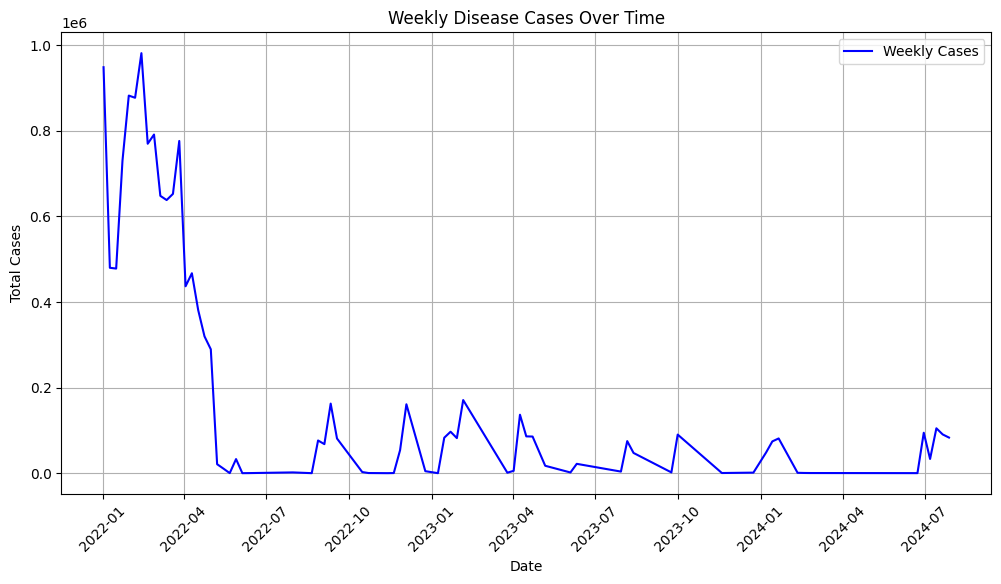

In [ ]:
print(merged_df[['mmwr_year', 'mmwr_week']].isnull().sum())
merged_df = merged_df.dropna(subset=['mmwr_year', 'mmwr_week'])

# Alternatively, you can fill missing values with default values (e.g., using a placeholder year/week)
# merged_df['mmwr_year'].fillna(2020, inplace=True)  # or any other valid year
# merged_df['mmwr_week'].fillna(1, inplace=True)    # or any other valid week

merged_df['date'] = pd.to_datetime(
    merged_df['mmwr_year'].astype(str) + merged_df['mmwr_week'].astype(str).str.zfill(2) + '0',
    format='%Y%U%w'
)

weekly_trends = merged_df.groupby('date')['current_week'].sum()

plt.figure(figsize=(12, 6))
plt.plot(weekly_trends.index, weekly_trends.values, color='b', label='Weekly Cases')
plt.title("Weekly Disease Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

* The plot shows weekly disease cases over time. At the beginning (early 2022), there’s a very high number of cases, with several peaks and drops, suggesting possible disease outbreaks (COVID-19) or high reporting activity in those weeks.
* After the initial period, there’s a steep decline in cases, which then stabilize at a much lower level. This pattern could indicate that the early peak was an unusual period, either due to an outbreak or data reporting adjustments.

### 2. Rolling Average (Smoothing the Trend)

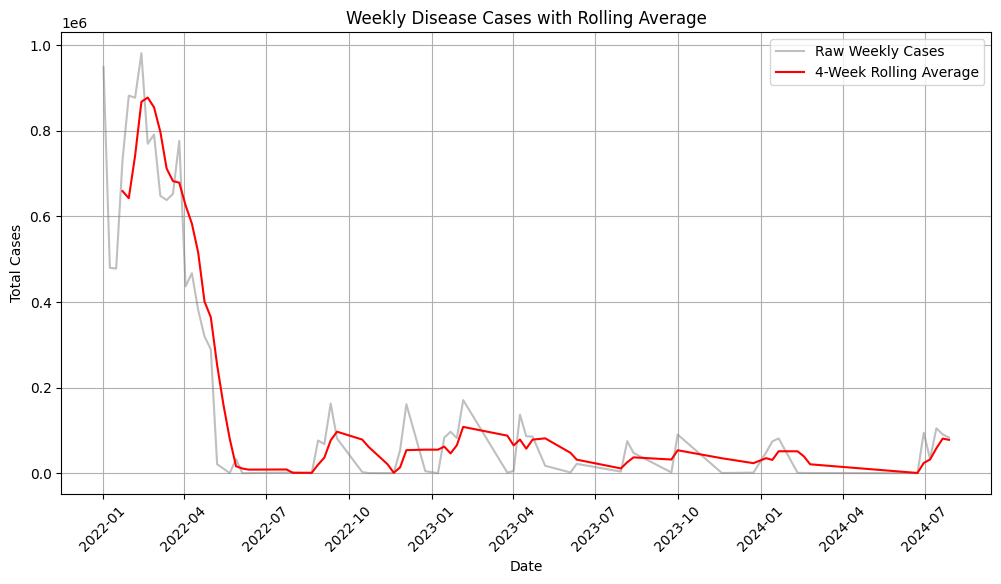

In [ ]:
weekly_trends_rolling = weekly_trends.rolling(window=4).mean()

plt.figure(figsize=(12, 6))
plt.plot(weekly_trends.index, weekly_trends.values, color='gray', alpha=0.5, label='Raw Weekly Cases')
plt.plot(weekly_trends_rolling.index, weekly_trends_rolling.values, color='red', label='4-Week Rolling Average')
plt.title("Weekly Disease Cases with Rolling Average")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


### 3. Seasonal Decomposition of Time Series (For Trend, Seasonal, and Residual Components)

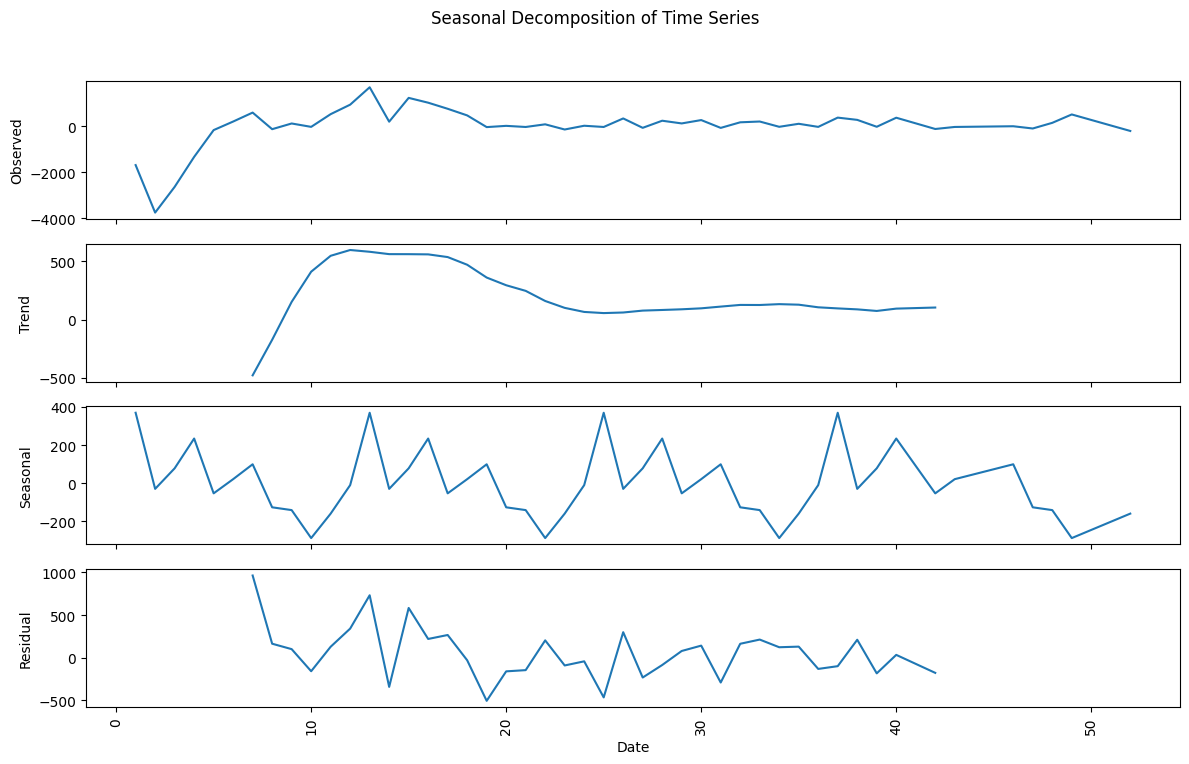

In [ ]:
decomposition = sm.tsa.seasonal_decompose(weekly_trends, model='additive', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Seasonal Decomposition of Time Series")

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.tick_params(axis='x', rotation=90)

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.tick_params(axis='x', rotation=90)

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.tick_params(axis='x', rotation=90)

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.tick_params(axis='x', rotation=90)

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1. **Observed**:
   - The observed plot is the raw data, showing how cases change over time. By viewing this, we can get a high-level idea of the data's behavior, such as any sudden peaks or prolonged increases. Observing this alone, however, doesn’t tell us if fluctuations are due to long-term trends, recurring cycles, or random noise.

2. **Trend**:
   - The trend component represents the long-term direction of the data, smoothing out short-term fluctuations. By isolating this, we can see if cases are generally increasing, decreasing, or stabilizing over a longer period.
   - This is useful because, in public health data, a sustained upward trend might indicate a persistent outbreak or worsening condition, while a downward trend could mean successful containment or reduced reporting over time.

3. **Seasonal**:
   - The seasonal component captures repeating patterns at regular intervals. In this case, it helps us see if there’s a weekly, monthly, or yearly cycle in disease cases, which is common with seasonal diseases (e.g., flu cases rising in winter).
   - Recognizing seasonality is valuable because it enables us to predict when cases might rise again, helping in planning resources and preventive actions. For instance, if disease cases rise every 12 weeks, health systems can prepare for these periods.

4. **Residual**:
   - The residual component shows the remaining variation after removing the trend and seasonal effects. This often includes random noise, unusual events, or anomalies.
   - Analyzing residuals is important because unexpected spikes here could indicate rare events (e.g., an outbreak outside the usual season), data quality issues, or changes in reporting practices. High residuals might prompt a closer look to investigate and understand what caused those deviations.

### 4. Detecting Seasonality with Heatmaps (for Week/Year Based Data)

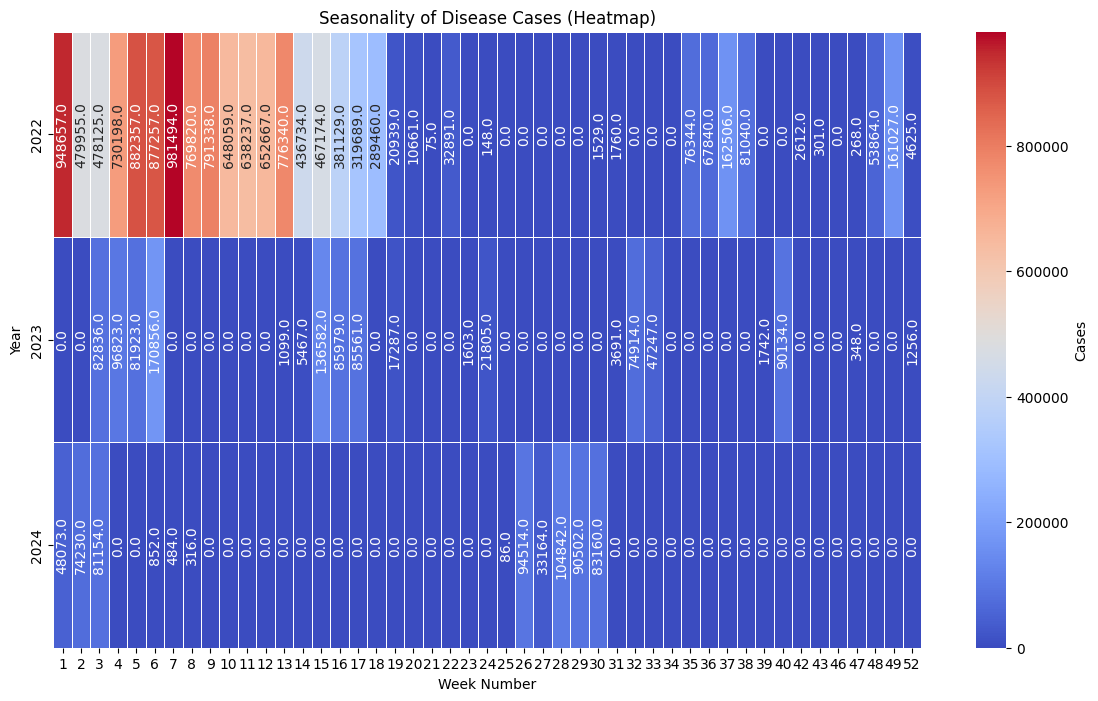

In [ ]:
weekly_cases = merged_df.groupby(['mmwr_year', 'mmwr_week'])['current_week'].sum().reset_index()
heatmap_data = weekly_cases.pivot(index='mmwr_year', columns='mmwr_week', values='current_week')

# Fill NaN values with 0 and convert the entire DataFrame to float
heatmap_data = heatmap_data.fillna(0).astype(float)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data, cmap='coolwarm', annot=True, fmt='.1f', cbar_kws={'label': 'Cases'}, linewidths=0.5,
    annot_kws={"rotation": 90}
)
plt.title("Seasonality of Disease Cases (Heatmap)")
plt.xlabel("Week Number")
plt.ylabel("Year")
plt.show()

1. Interpretation of Colors:

- The color scale (from blue to red) represents the case count, with red indicating higher cases and blue showing lower cases.
- The intense red blocks at the start of 2022 signify high case counts in those early weeks (COVID-19), likely due to an outbreak or reporting surge.
- The consistent blue in 2023 and 2024 suggests significantly lower or controlled case numbers in most weeks, indicating stabilization.

2. Seasonal Patterns:

- The heatmap highlights any recurring patterns across weeks in different years. For instance, if certain weeks across years show warmer colors (more cases), it could indicate a seasonal effect.
- However, in this data, there is no strong seasonality pattern across all years, though specific spikes in early 2022 are notable.

## Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
merged_df[['current_week', 'previous_52_week_max', 'cumulative_ytd', 'cumulative_ytd_previous']] = scaler.fit_transform(
    merged_df[['current_week', 'previous_52_week_max', 'cumulative_ytd', 'cumulative_ytd_previous']]
)

In [ ]:
merged_df['disease_name'] = merged_df['disease_name'].fillna('Unknown')
merged_df['location_name'] = merged_df['location_name'].fillna('Unknown')
merged_df['states_x'] = merged_df['states_x'].fillna('Unknown')
merged_df['states_y'] = merged_df['states_y'].fillna('Unknown')

merged_df['longitude'] = merged_df['longitude'].fillna(merged_df['longitude'].mean())
merged_df['latitude'] = merged_df['latitude'].fillna(merged_df['latitude'].mean())

merged_df['state'] = merged_df['states_x'].combine_first(merged_df['states_y'])
merged_df = merged_df.drop(columns=['states_x', 'states_y'])

merged_df = merged_df.dropna(subset=['location_id', 'mmwr_year', 'mmwr_week'])

print(merged_df.isnull().sum())

data_id                         0
location_id                     0
report_id                       0
disease_id                      0
current_week                    0
current_week_flag               0
previous_52_week_max            0
previous_52_week_max_flag       0
cumulative_ytd                  0
cumulative_ytd_flag             0
cumulative_ytd_previous         0
cumulative_ytd_previous_flag    0
disease_name                    0
location_name                   0
longitude                       0
latitude                        0
mmwr_year                       0
mmwr_week                       0
date                            0
state                           0
dtype: int64


## Data Visualisation after Normalisation

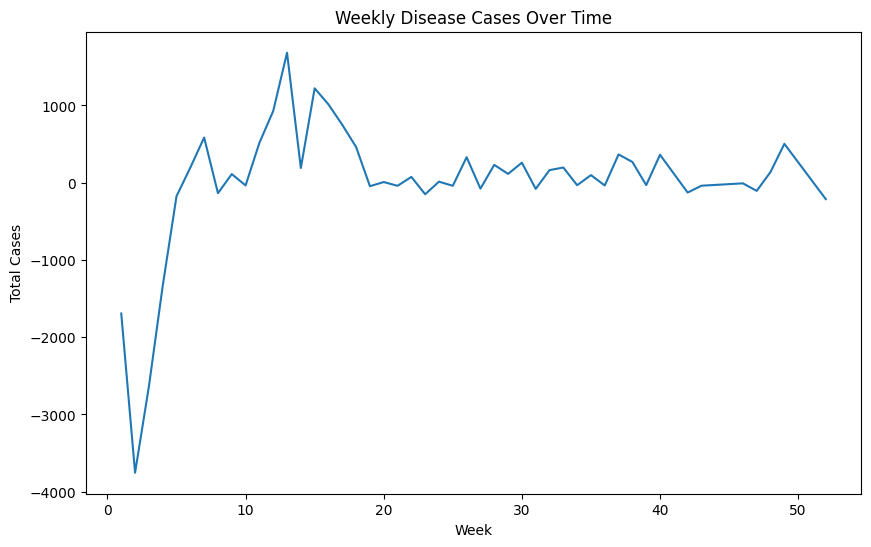

In [ ]:
weekly_trends = merged_df.groupby("mmwr_week")["current_week"].sum()
weekly_trends.plot(kind="line", figsize=(10, 6))
plt.title("Weekly Disease Cases Over Time")
plt.xlabel("Week")
plt.ylabel("Total Cases")
plt.show()

In [ ]:
negative_cases = merged_df[merged_df['current_week'] < 0]
print(negative_cases[['mmwr_week', 'current_week', 'disease_name', 'location_name']])

         mmwr_week  current_week  \
0                3     -0.040282   
1                3     -0.040282   
2                3     -0.040282   
3                3     -0.040282   
4                3     -0.040282   
...            ...           ...   
2130993          2     -0.040282   
2130994          2     -0.040282   
2130995          2     -0.040282   
2130996          2     -0.040282   
2130997          2     -0.040282   

                                              disease_name location_name  
0        Vibriosis (any species of the family Vibrionac...       Unknown  
1        Vibriosis (any species of the family Vibrionac...       Unknown  
2        Vibriosis (any species of the family Vibrionac...       Unknown  
3                    Viral hemorrhagic fevers, Ebola virus       Unknown  
4                    Viral hemorrhagic fevers, Ebola virus       Unknown  
...                                                    ...           ...  
2130993                                   

Since the data is normalized, the plot illustrates trends in case intensity rather than exact counts. Peaks represent weeks with higher-than-average cases, while troughs indicate below-average weeks.

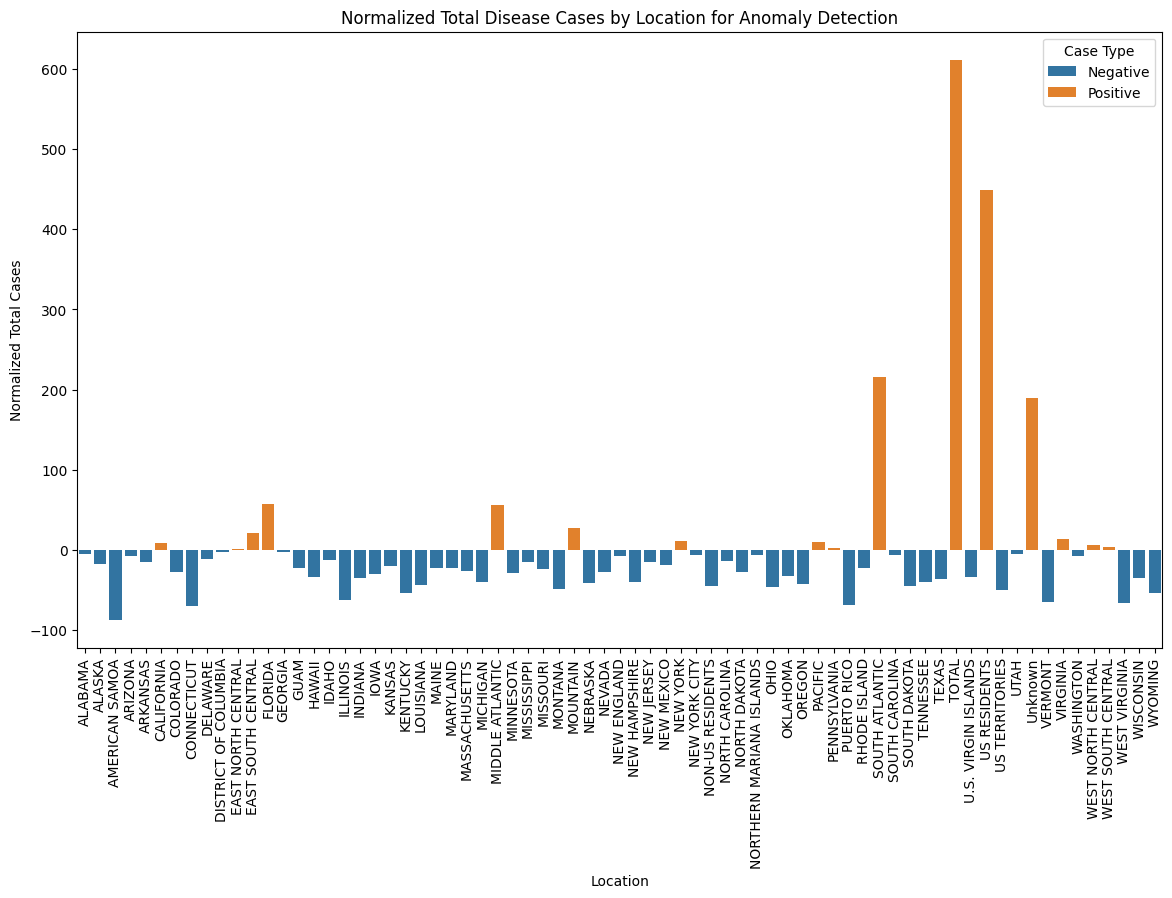

In [ ]:
location_cases = merged_df.groupby("location_name")["current_week"].sum().reset_index()
location_cases['Color'] = location_cases['current_week'].apply(lambda x: 'Negative' if x < 0 else 'Positive')

plt.figure(figsize=(14, 8))
sns.barplot(x="location_name", y="current_week", hue="Color", data=location_cases, dodge=False)
plt.xticks(rotation=90)
plt.title("Normalized Total Disease Cases by Location for Anomaly Detection")
plt.xlabel("Location")
plt.ylabel("Normalized Total Cases")
plt.legend(title="Case Type")
plt.show()


   - This bar chart shows the normalized total disease cases for each location, with bars classified as "Positive" (above average) or "Negative" (below average) cases, based on the `current_week` column.

   - **Positive Bars (Orange)**: Locations with bars above zero indicate weeks with above-average case counts after normalization. These are highlighted as potential anomalies or hotspots.
   - **Negative Bars (Blue)**: Locations with bars below zero had below-average case counts, suggesting they experienced fewer cases relative to the normalized mean.

   - Certain locations, like "U.S. VIRGIN ISLANDS" and "PACIFIC," show substantial positive values, indicating that these areas had significantly higher case counts relative to the normalized average. These could be areas of interest for further investigation.
   - Many locations have negative totals, which could indicate that they had fewer cases or consistent low reporting compared to the mean, making them less likely to be anomalies.

   - This visualization is useful for spotting outliers and anomalies across locations, as it highlights areas that deviate significantly from the average. It can help prioritize locations for further analysis or resources.

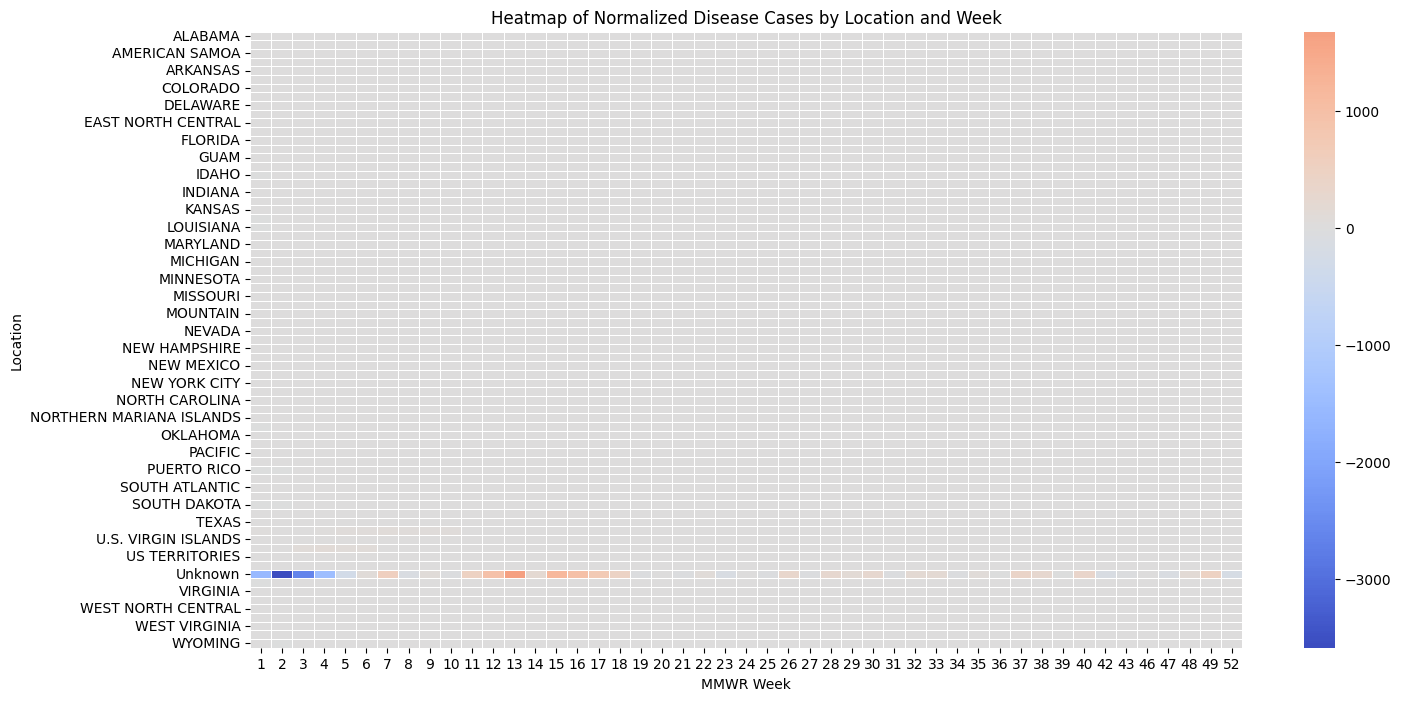

In [ ]:
heatmap_data = merged_df.pivot_table(index="location_name", columns="mmwr_week", values="current_week", aggfunc="sum", fill_value=0)

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0, annot=False, fmt="d", linewidths=0.5)
plt.title("Heatmap of Normalized Disease Cases by Location and Week")
plt.xlabel("MMWR Week")
plt.ylabel("Location")
plt.show()


Since the data is normalized, the heatmap shows relative intensity rather than absolute counts, making it easier to detect patterns but not the exact number of cases. Locations with consistent activity around the mean appear neutral, while any large deviations stand out.

## Anomaly Detection (Machine Learning)

###  Z-Score Method

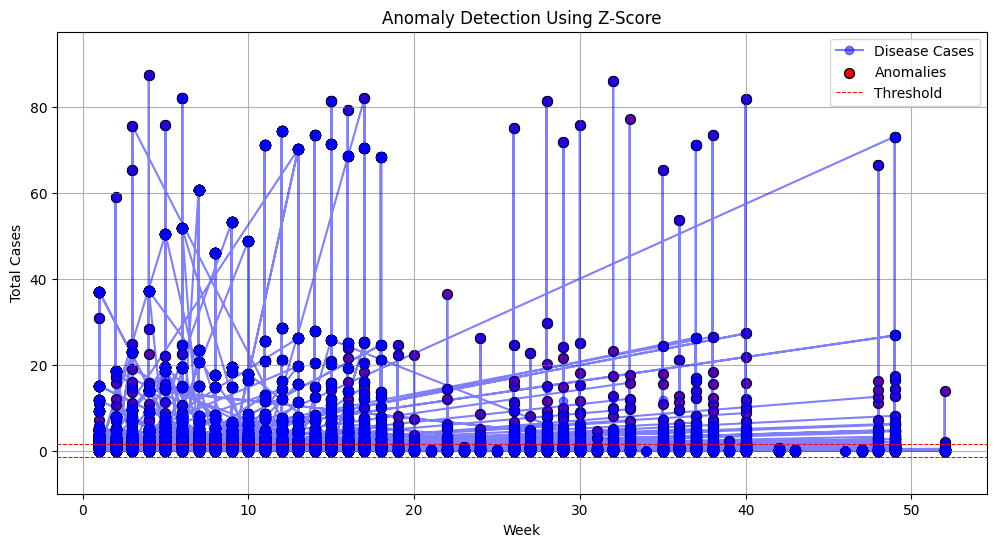

In [ ]:
window_size = 10  # This can be adjusted based on the analysis needs
merged_df['rolling_mean'] = merged_df['current_week'].rolling(window=window_size, min_periods=1).mean()
merged_df['rolling_std'] = merged_df['current_week'].rolling(window=window_size, min_periods=1).std()

# Calculate the Z-Score (Z = (x - mean) / std)
merged_df['z_score'] = (merged_df['current_week'] - merged_df['rolling_mean']) / merged_df['rolling_std']

threshold = 1.5
anomalies_zscore = merged_df[(merged_df['z_score'].abs() > threshold)]

# Visualize anomalies along with normal data
plt.figure(figsize=(12, 6))
plt.plot(merged_df['mmwr_week'], merged_df['current_week'], label="Disease Cases", marker='o', linestyle='-', alpha=0.5, color='blue')
plt.scatter(anomalies_zscore['mmwr_week'], anomalies_zscore['current_week'], color='red', label='Anomalies', edgecolors='k', s=50)

# Improve visualization
plt.title("Anomaly Detection Using Z-Score")
plt.xlabel("Week")
plt.ylabel("Total Cases")
plt.axhline(y=threshold, color='r', linestyle='--', linewidth=0.75, label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--', linewidth=0.75)
plt.grid(True)
plt.legend()

# Dynamic Y-axis scaling
plt.ylim([merged_df['current_week'].min() - 10, merged_df['current_week'].max() + 10])

plt.show()

The anomaly detection plot shows weekly disease case counts, with red dots highlighting weeks where cases significantly deviate from recent trends. By using a Z-score threshold, anomalies are clearly identified, indicating weeks with unusually high or low cases compared to a 10-week rolling mean. Most cases stay close to the mean, but spikes occur throughout the year, suggesting irregular surges in cases that may indicate outbreaks or data reporting anomalies. This visualization effectively highlights unusual patterns, aiding in the quick identification of weeks requiring further investigation.

### Isolation Forest Method

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)

data = merged_df[['current_week']]
iso_forest.fit(data)
merged_df['anomaly'] = iso_forest.predict(data)
merged_df['anomaly'] = merged_df['anomaly'].map({1: 0, -1: 1})

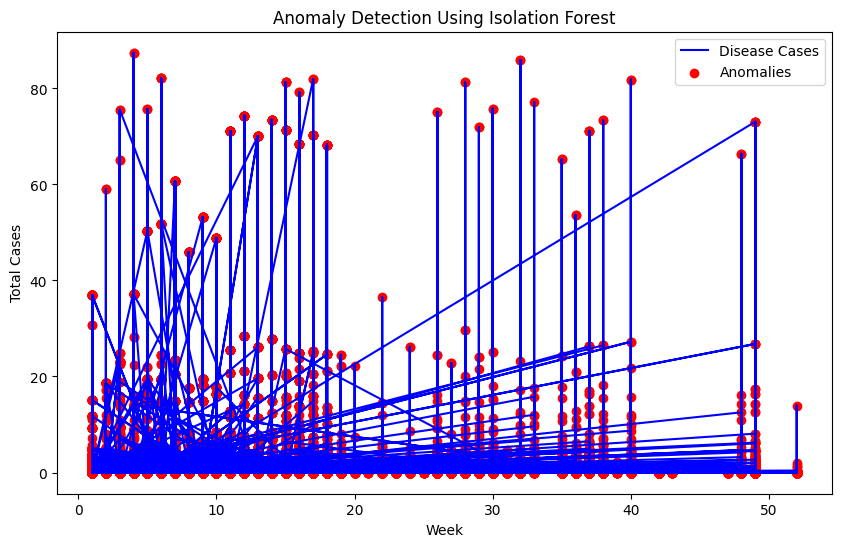

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['mmwr_week'], merged_df['current_week'], label="Disease Cases", color='blue')
anomalies = merged_df[merged_df['anomaly'] == 1]
plt.scatter(anomalies['mmwr_week'], anomalies['current_week'], color='red', label='Anomalies')

plt.title("Anomaly Detection Using Isolation Forest")
plt.xlabel("Week")
plt.ylabel("Total Cases")
plt.legend()
plt.show()

This plot visualizes anomaly detection using the Isolation Forest algorithm, highlighting weeks with unusual disease case counts. The blue line represents the overall weekly trend, while red dots indicate anomalies—data points flagged as outliers by the model. With a contamination setting of 5%, the algorithm expects about 5% of the points to be anomalies, identifying weeks with case counts that significantly differ from the overall pattern. The red dots are scattered across high, medium, and low case levels, suggesting that the Isolation Forest detects anomalies based on deviations from typical behavior, not just high spikes. This method effectively captures irregular weeks that might require further investigation.

### DBSCAN Method

In [ ]:
# data = merged_df[['current_week']]  # You can include more features if necessary
# dbscan = DBSCAN(eps=3, min_samples=5)
# merged_df['dbscan_labels'] = dbscan.fit_predict(data)
# merged_df['dbscan_anomaly'] = merged_df['dbscan_labels'].apply(lambda x: 1 if x == -1 else 0)

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(merged_df['mmwr_week'], merged_df['current_week'], label="Disease Cases", color='blue')

# # Highlight anomalies detected by DBSCAN
# anomalies_dbscan = merged_df[merged_df['dbscan_anomaly'] == 1]
# plt.scatter(anomalies_dbscan['mmwr_week'], anomalies_dbscan['current_week'], color='red', label='DBSCAN Anomalies')

# plt.title("Anomaly Detection Using DBSCAN")
# plt.xlabel("Week")
# plt.ylabel("Total Cases")
# plt.legend()
# plt.show()

DBSCAN cannot work with extremely large dataset and causes the code to crash.

## Model evaluation

In [ ]:
merged_df['actual_labels'] = merged_df['current_week'].apply(lambda x: 1 if x > threshold else 0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(merged_df.columns)

if 'actual_labels' not in merged_df.columns:
    raise KeyError("The 'actual_labels' column is missing from your DataFrame!")

Index(['data_id', 'location_id', 'report_id', 'disease_id', 'current_week',
       'current_week_flag', 'previous_52_week_max',
       'previous_52_week_max_flag', 'cumulative_ytd', 'cumulative_ytd_flag',
       'cumulative_ytd_previous', 'cumulative_ytd_previous_flag',
       'disease_name', 'location_name', 'longitude', 'latitude', 'mmwr_year',
       'mmwr_week', 'date', 'state', 'rolling_mean', 'rolling_std', 'z_score',
       'anomaly', 'outliers', 'actual_labels'],
      dtype='object')


In [ ]:
model = IsolationForest(contamination=0.1)
merged_df['outliers'] = model.fit_predict(merged_df[['current_week']])

In [ ]:
predicted_labels = merged_df['outliers'].map({-1: 1, 1: 0})  # 1 = anomaly, 0 = normal
true_labels = merged_df['actual_labels']

In [ ]:
merged_df[['current_week', 'rolling_mean', 'rolling_std']] = merged_df[['current_week', 'rolling_mean', 'rolling_std']].fillna(merged_df[['current_week', 'rolling_mean', 'rolling_std']].mean())

model = IsolationForest(contamination=0.01, random_state=42)
merged_df['outliers'] = model.fit_predict(merged_df[['current_week', 'rolling_mean', 'rolling_std']])
predicted_labels = merged_df['outliers'].map({-1: 1, 1: 0})
true_labels = merged_df['actual_labels']

print("Confusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print('\n')
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Confusion Matrix:
[[1821555   14124]
 [      0    4264]]



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1835679
           1       0.23      1.00      0.38      4264

    accuracy                           0.99   1839943
   macro avg       0.62      1.00      0.69   1839943
weighted avg       1.00      0.99      0.99   1839943



#### **Contamination Level**
- A contamination level of **0.01** (1%) was chosen, indicating that only 1% of the data is expected to be anomalies. This aligns with the nature of anomaly detection, where true outliers are rare. This low contamination setting helps the model to be selective in identifying unusual cases, ensuring that only significant deviations are flagged as anomalies.

#### **Confusion Matrix and Performance Metrics**
- **True Negatives**: The model successfully identifies the majority of normal (non-anomalous) weeks, indicating that it accurately recognizes typical fluctuations in weekly case counts.
- **False Positives**: A relatively small number of normal cases are misclassified as anomalies. This indicates a well-calibrated model that avoids over-flagging, though some false positives are expected in any anomaly detection task.
- **True Positives**: All true anomalies are detected by the model.
- **Precision for Anomalies**: With a precision of 0.23 for anomalies, the model shows that while it captures all anomalies, some cases labeled as anomalies may still be normal. This precision level is reasonable for anomaly detection, as it indicates that flagged cases should be reviewed, but most are likely worth investigating.

### **Classification Report Insights**
- **High Recall (1.0)**: The model’s ability to capture all true anomalies is excellent, indicating it is sensitive enough to identify any week with a significant deviation from typical patterns.
- **Balanced Precision and F1-Score**: The model achieves a balance between capturing true anomalies and minimizing false positives. The F1-score of 0.38 for anomalies shows a good trade-off between recall and precision, providing confidence in the model's flagged cases as likely true deviations.

### **Interpretation and Practicality**
- **Effective Use of Rolling Statistics**: By including rolling mean and standard deviation, the model effectively adapts to changing patterns in the data. This setup allows it to account for recent trends and avoid flagging seasonal or expected fluctuations as anomalies.
- **Real-World Relevance**: This model setup is practical for real-world disease data, where true anomalies are rare, and it’s crucial to detect significant deviations while minimizing false alarms. The model’s high recall and improved precision make it well-suited for early detection of potential disease outbreaks or unusual reporting patterns.